In [2]:
from utils import *
sda = spatialHM()
sda.check_torch_gpu()

-------------------------------------------------
------------------ VERSION INFO -----------------
Conda Environment: torchy | Python version: 3.8.16 (default, Mar  2 2023, 03:18:16) [MSC v.1916 64 bit (AMD64)]
Torch version: 2.0.1
Torch build with CUDA? True
# Device(s) available: 1, Name(s): Quadro P520



In [146]:
from pyesmda import ESMDA, ESMDA_RS
from scipy.io import loadmat

In [170]:
logperm = np.array(pd.read_csv('simulations/perm_64_32168.csv')).reshape(64,64,501).T
print(logperm.shape)

(501, 64, 64)


In [168]:
saturation = np.zeros((5,30,64,64))
for i in range(5):
    for j in range(30):
        saturation[i,j] = loadmat('simulations/states/states{}.mat'.format(i+1), simplify_cells=True)['states'][j]['s'][:,1].reshape(64,64)

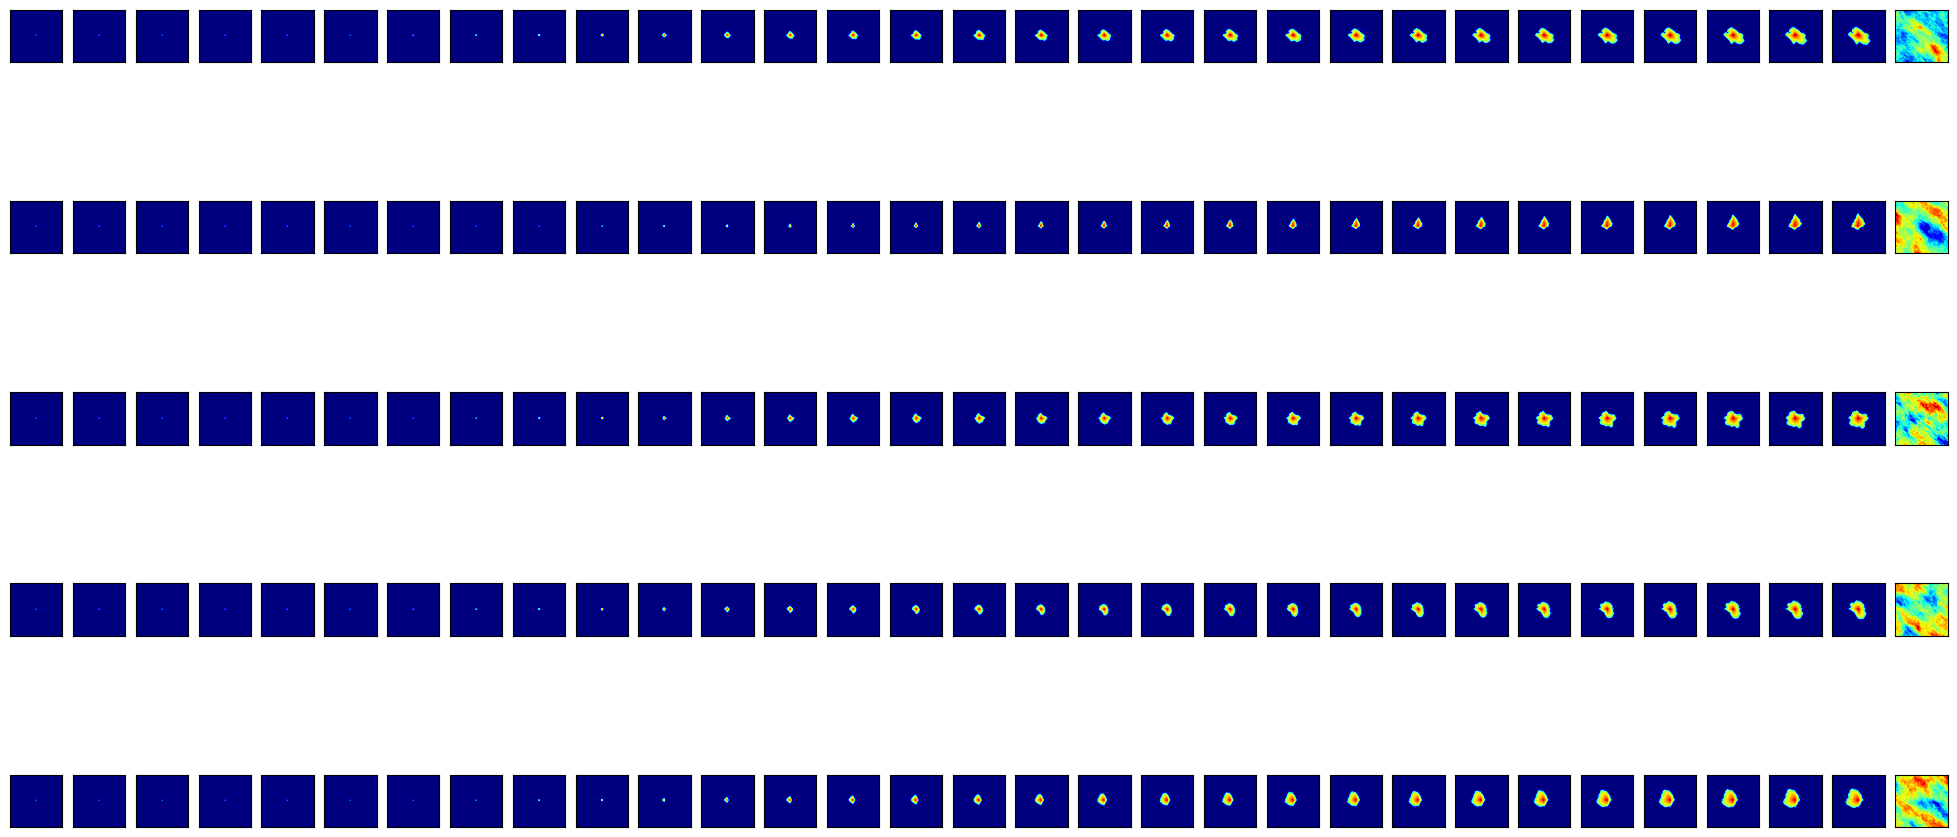

In [174]:
fig, axs = plt.subplots(5, 31, figsize=(25,12))
for i in range(5):
    for j in range(30):
        axs[i,j].imshow(saturation[i,j], 'jet')
    axs[i,30].imshow(logperm[i], 'jet')
    for j in range(31):
        axs[i,j].set(xticks=[], yticks=[])
plt.show()

In [195]:
saturation.shape

(5, 30, 64, 64)

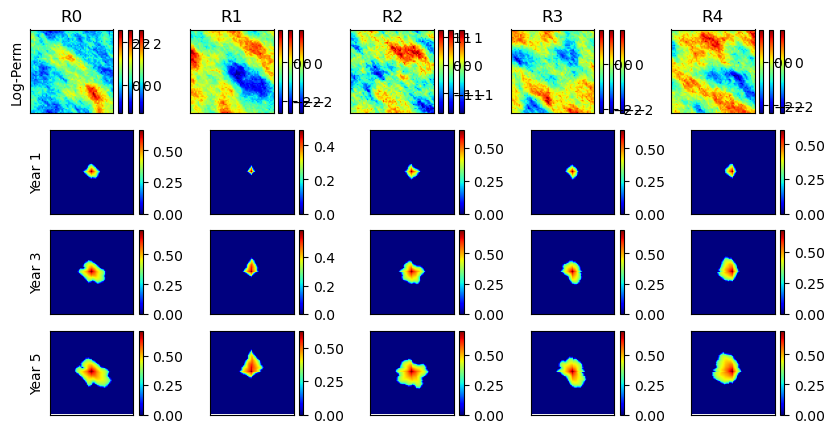

In [217]:
idx_1 = np.where(loadmat('simulations/timesteps.mat')['t']==1)[0][0]
idx_3 = np.where(loadmat('simulations/timesteps.mat')['t']==3)[0][0]
idx_5 = np.where(loadmat('simulations/timesteps.mat')['t']==5)[0][0]
idx = [idx_1, idx_3, idx_5]
years = [1,3,5]

fig, axs = plt.subplots(4, 5, figsize=(10,5))
for j in range(5):
    for i in range(1,4):
        ims = axs[i,j].imshow(saturation[j,idx[i-1]], 'jet')
        imp = axs[0,j].imshow(logperm[j], 'jet')
        axs[0,j].set(title='R{}'.format(j)); axs[i,0].set(ylabel='Year {}'.format(years[i-1]))
        plt.colorbar(ims, fraction=0.046, pad=0.04)
        plt.colorbar(imp, fraction=0.046, pad=0.04)
    for i in range(4): 
        axs[i,j].set(xticks=[], yticks=[])
axs[0,0].set(ylabel='Log-Perm')
plt.show()
        

In [25]:
def forward_model(m_ensemble, x):
    d_pred = np.zeros([m_ensemble.shape[0], x.shape[0]])
    for j in range(m_ensemble.shape[0]):
        d_pred[j,:] = exponential(m_ensemble[j,:], x)
    return d_pred

In [53]:
a = 10
b = -0.0020

# Observations
x = np.arange(500) #timesteps
obs = exponential((a,b), x) + np.random.normal(0, 1, x.shape[0])
cov_obs = np.diag([1]*obs.shape[0])

# Ensemble of parameters
n_ensemble = 100
ma = np.random.uniform(-10, 50, size=n_ensemble)
mb = np.random.uniform(-0.001, 0.01, size=n_ensemble)
m_ensemble = np.stack((ma,mb), axis=1)
m_bounds = np.array([[0,50],[-1,1]])

n_assimilations = 3

cov_obs_inflation_geo = 1.2
cov_obs_inflation_factors = [1.1]
for l in range(1, n_assimilations):
    cov_obs_inflation_factors.append(cov_obs_inflation_factors[l - 1] / cov_obs_inflation_geo)
scaling_factor = np.sum(1 / np.array(cov_obs_inflation_factors))
cov_obs_inflation_factors = [alpha * scaling_factor for alpha in cov_obs_inflation_factors]

cov_mm_inflation_factors = [1.2] * n_assimilations

solver = ESMDA(obs, m_ensemble, cov_obs, forward_model, 
               forward_model_args        = (x,),
               forward_model_kwargs      = {},
               n_assimilations           = n_assimilations,
               cov_obs_inflation_factors = cov_obs_inflation_factors,
               cov_mm_inflation_factors  = cov_mm_inflation_factors,
               m_bounds                  = m_bounds,
               save_ensembles_history    = True)
solver.solve()


#approxtimate parameters
a_approx, b_approx = np.average(solver.m_prior, axis=0)
a_std, b_std = np.sqrt(np.diagonal(solver.cov_mm))

print('a={:.5f} +/- {:.5f}'.format(a_approx, a_std))
print('b={:.5f} +/- {:.5f}'.format(b_approx, b_std))

Assimilation # 1
Assimilation # 2
Assimilation # 3
a=10.07754 +/- 0.13415
b=-0.00203 +/- 0.00009


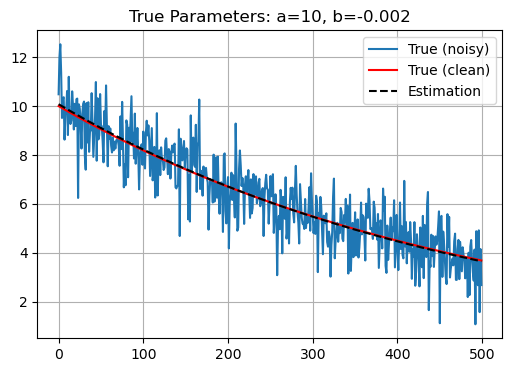

In [61]:
plt.figure(figsize=(6,4))
plt.plot(x, obs, '-', label='True (noisy)')
plt.plot(x, exponential((a,b),x), 'r-', label='True (clean)')
plt.plot(x, exponential((a_approx, b_approx),x), 'k--', label='Estimation')
plt.title('True Parameters: a={}, b={}'.format(a,b))
plt.legend(); plt.grid('on')
plt.show()

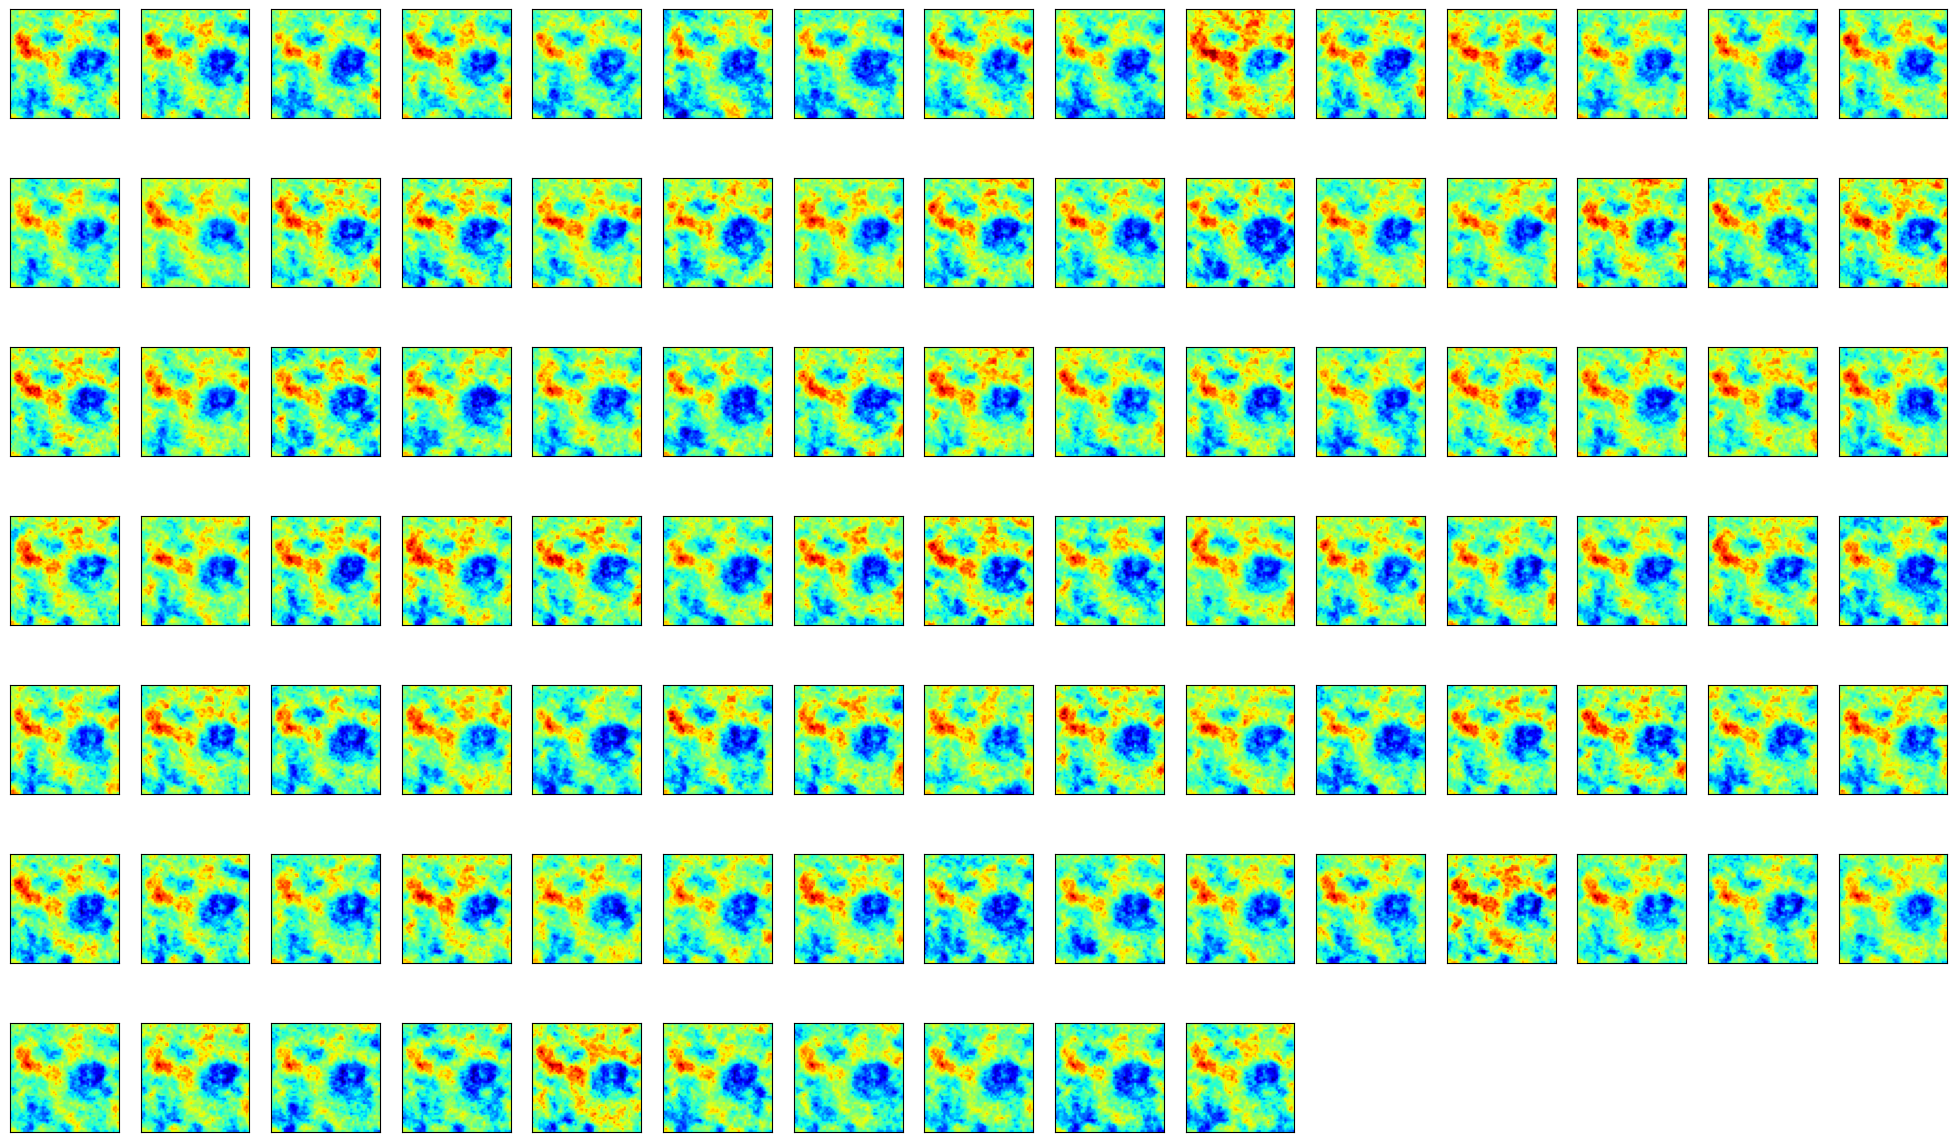

In [15]:
temp = np.loadtxt('Results_postprocessing/1n3n5_10p/param_1_4.txt').reshape(51,51,100).T

plt.figure(figsize=(25,15))
for i in range(100):
    plt.subplot(7,15,i+1)
    plt.imshow(np.log10(temp[i]), 'jet')
    plt.xticks([]); plt.yticks([])
plt.show()

***
# END